<h1 align=center><font size = 10> k-Means </font></h1>

In this notebook, we try to practice one of the most popular algorithms in Clustering that we learned in this course: k-Means algorithm. 

We load a dataset using Pandas library and apply k-Means to explore information from data.
Lets first load required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty


A convenience function for you to use:

In [2]:
def clusterInfo(model):
    print("  Cluster Analysis Inertia: ", model.inertia_)
    print('  ----------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("    Cluster ", i)
        print("      Centroid ", model.cluster_centers_[i])
        print("      #Samples ", (model.labels_==i).sum()) # NumPy Power
        

In [3]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_) # len(data)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)


# Mandatory part (85%  of the total score)

### About dataset

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) 

*   List item
*   List item

(CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The questions you'll be exploring in this lab assignment using K-Means are: exactly how useful is telephone metadata? It must have some use, otherwise, the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records of 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!


**1. Start by loading up the dataset and taking a peek at its head. You have to convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:**

In [4]:
#TO DO:
data = pd.read_csv('CDR.csv')
data.head()


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


In [5]:
#convert data type
data['CallDate'] = pd.to_datetime(data['CallDate'])
data['CallTime'] = pd.to_timedelta(data['CallTime'])
data['Duration'] = pd.to_timedelta(data['Duration'])
data.dtypes


In                     int64
Out                    int64
Direction             object
CallDate      datetime64[ns]
CallTime     timedelta64[ns]
DOW                   object
Duration     timedelta64[ns]
TowerID               object
TowerLat             float64
TowerLon             float64
dtype: object

**2. Create a distinct list of `In` phone numbers (people) and store the values in a regular python list.**

Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [6]:
#TO DO:
In_phone_numbers = data.In.tolist()
phone_numbers_list = []
for value in In_phone_numbers:
    if value not in phone_numbers_list:
        phone_numbers_list.append(value)
phone_numbers_list


[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

**3. Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:**

In [7]:
#TO DO:
user1 = data[data.In==phone_numbers_list[0]]
user1.head()


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,00:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,00:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,00:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,00:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,00:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


**4. Let's go ahead and plot all the call locations for user 1 in all time:**


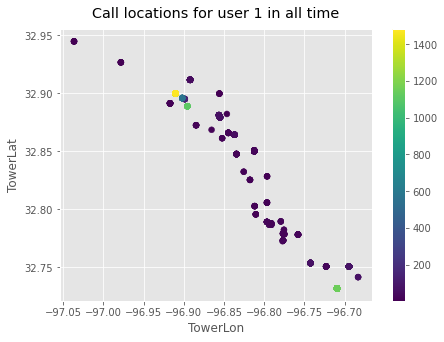

In [8]:
#TO DO:
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 

# Calculate the point density
x = user1.TowerLon
y = user1.TowerLat
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y, c=z, s=35,)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
plt.title('Call locations for user 1 in all time', y=1.02)
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()


INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

**5. Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):**

In [9]:
#TO DO:
user1['weekends'] = (user1.DOW=="Sat") | (user1.DOW=="Sun")
user1_weekends = user1[user1.weekends==True]
print(user1_weekends.shape)
user1_weekends.head()


(1141, 11)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,weekends
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,00:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,00:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500,True
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,00:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,00:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,00:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,True


**6. Further filter `user1` down for calls that came in either before 6am OR after 10pm (22:00:00).**

Even if you didn't convert your times from string objects to time deltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [10]:
#TO DO:
user1_weekends_hours = user1_weekends.query('(CallTime<"06:00:00") | (CallTime>"22:00:00")')
print(user1_weekends_hours.shape)
user1_weekends_hours.head()
                                            

(28, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,weekends
940,4638472273,6150928001,Incoming,2011-01-08,22:22:33.693878,Sat,00:00:35.065912,26f7441e-e64b-4b9d-8c5a-0eb34f7e919f,32.731611,-96.709417,True
1875,4638472273,2145623768,Incoming,2011-01-22,22:21:27.466908,Sat,00:03:40.018320,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
6949,4638472273,5621270003,Missed,2011-04-09,22:59:23.206408,Sat,00:03:06.567364,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
7468,4638472273,7756914135,Incoming,2011-04-17,05:15:40.205917,Sun,00:02:09.984993,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500,True
9753,4638472273,7922223441,Incoming,2011-05-21,05:08:20.121145,Sat,00:01:30.059591,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True


**7. Visualize the dataframe with a scatter plot as a sanity check.**

Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based on the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

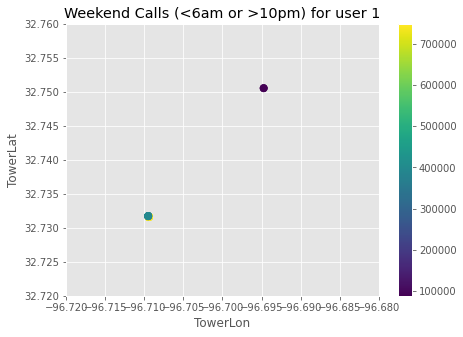

In [11]:
#TO DO:
x = user1_weekends_hours.TowerLon
y = user1_weekends_hours.TowerLat
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y, c=z, s=55,)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
plt.title('Weekend Calls (<6am or >10pm) for user 1');
plt.xlim(-96.72, -96.68);
plt.ylim(32.72, 32.76);
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()


**8. Run K-Means on that dataframe with `K=2` then print out the Cluster Info using clusterInfo function**, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required.

In [12]:
#TO DO:
from sklearn.cluster import KMeans 
model = KMeans(init="k-means++", n_clusters=2, n_init=10)
model.fit(user1_weekends_hours[['TowerLon', 'TowerLat']])
clusterInfo(model)


  Cluster Analysis Inertia:  1.1304346153788864e-07
  ----------------------------------------
    Cluster  0
      Centroid  [-96.70944573  32.73164942]
      #Samples  26
    Cluster  1
      Centroid  [-96.694722  32.750556]
      #Samples  2


**9. Add centroid locations onto your scatter plot. Use a distinguishable marker and color.**

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

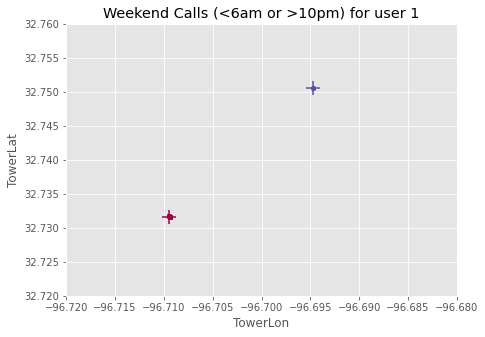

In [13]:
#TO DO:
fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(model.labels_))))
for k, col in zip(range(len(model.cluster_centers_)), colors):
    my_members = (model.labels_ == k)
    cluster_center = model.cluster_centers_[k]
    X = user1_weekends_hours.loc[my_members, 'TowerLon']
    Y = user1_weekends_hours.loc[my_members, 'TowerLat']
    ax.scatter(X, Y, color=col, marker='o', s=20)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, marker='+', s=200)

plt.title('Weekend Calls (<6am or >10pm) for user 1');
plt.xlim(-96.72, -96.68);
plt.ylim(32.72, 32.76);
plt.xlabel('TowerLon');
plt.ylabel('TowerLat'); 
 

**10. Now that you have a system in place, repeat the above steps (4, 8, and 9) for all 10 individuals in the dataset**. 

You might want to use a for-loop unless you enjoy copying and pasting:

In [14]:
# Create data for each user
users_alltime = []
for phone_number in phone_numbers_list:
    user = data[data.In==phone_number]
    users_alltime.append(user)
users_alltime[0].head()


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,00:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,00:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,00:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,00:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,00:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


**Plot all the call locations for users in all time:**


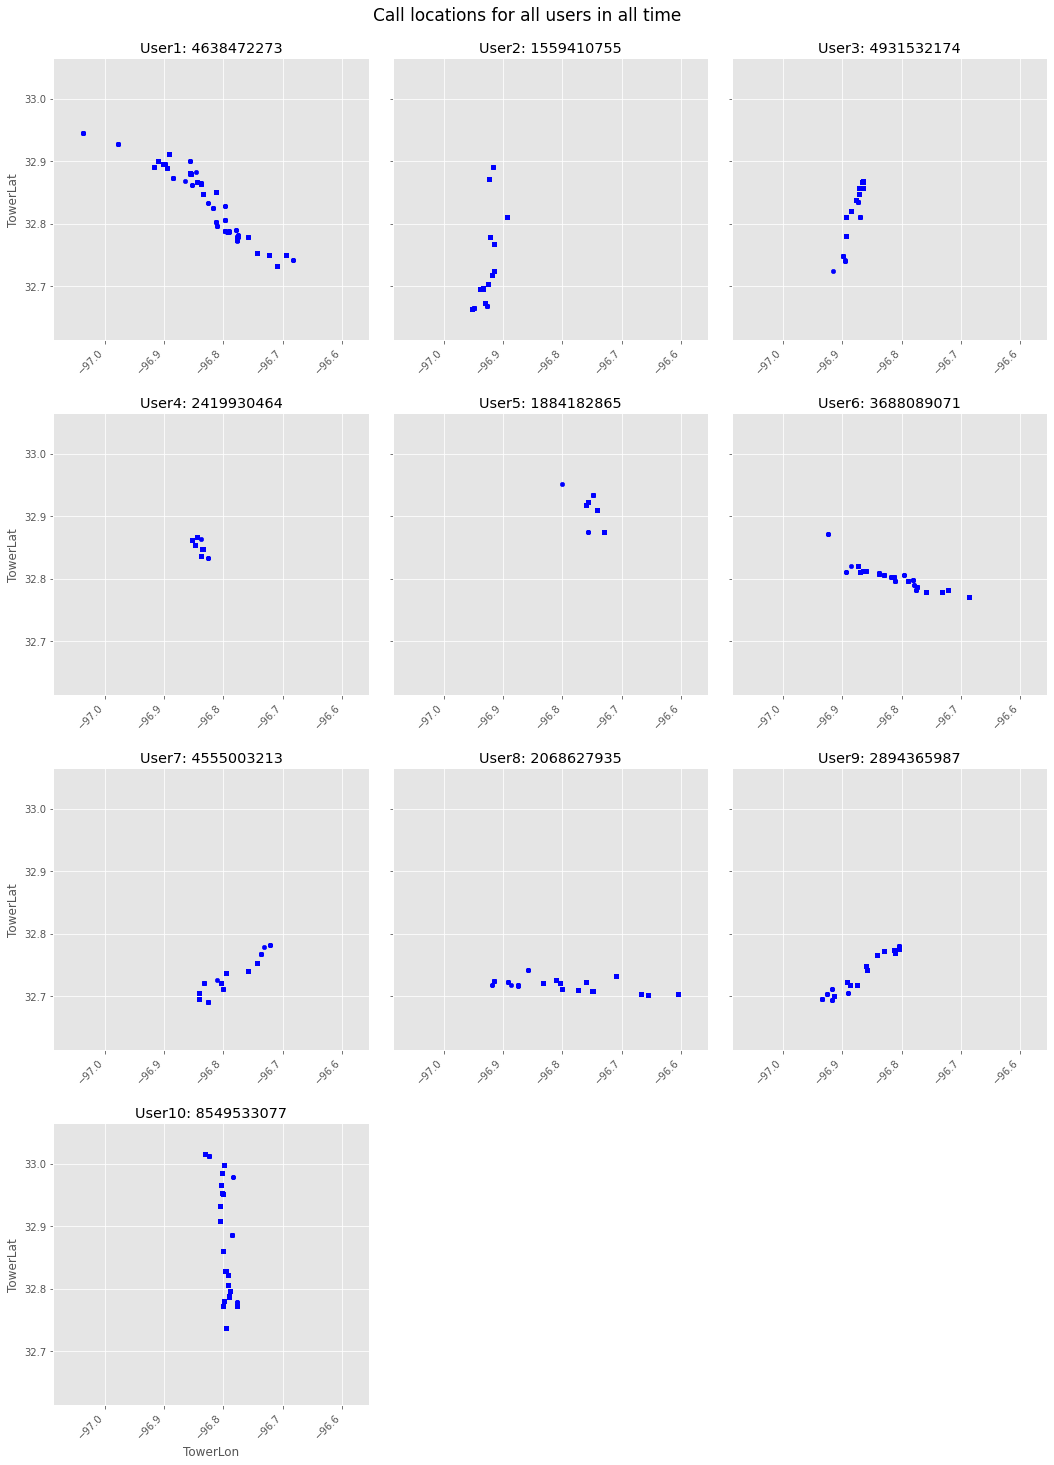

In [15]:
# Plot all the call locations for all users in all time.
plt.figure(figsize=(15, 20))
# setting axis scale
x_min = data['TowerLon'].min()
x_max = data['TowerLon'].max()
y_min = data['TowerLat'].min()
y_max = data['TowerLat'].max()

for idx, user in enumerate(users_alltime):
    ax = plt.subplot(4, 3, idx+1)
    X = user['TowerLon']
    Y = user['TowerLat']
    ax.scatter(X, Y, color='blue', marker='o', s=20)
    ax.set_xlim(x_min-0.05, x_max+0.05)
    ax.set_ylim(y_min-0.05, y_max+0.05)        
    ax.ticklabel_format(useOffset=False)
    if idx%3 == 0:
        ax.set_ylabel('TowerLat')
    else:
        ax.set_yticklabels([])
    ax.set_title('User{}: {}'.format(idx+1, phone_numbers_list[idx]))
    plt.xticks(rotation=45, ha='right')
        
plt.tight_layout(pad=2, w_pad=2, h_pad=2)
plt.suptitle('Call locations for all users in all time', size=17, y=1.01);
plt.xlabel('TowerLon');


**Run K-Means on weekend's data of users with `K=2` then print out the Cluster Info using clusterInfo function**

In [16]:
#Create data for each user
data['weekends'] = (data.DOW=="Sat") | (data.DOW=="Sun")
data_weekends = data[data.weekends==True]
data_weekends_hours = data_weekends.query('(CallTime<"06:00:00") | (CallTime>"22:00:00")')
users_weekends = []
for phone_number in phone_numbers_list:
    user = data_weekends_hours[data_weekends_hours.In==phone_number]
    users_weekends.append(user)
users_weekends[0].head()


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,weekends
940,4638472273,6150928001,Incoming,2011-01-08,22:22:33.693878,Sat,00:00:35.065912,26f7441e-e64b-4b9d-8c5a-0eb34f7e919f,32.731611,-96.709417,True
1875,4638472273,2145623768,Incoming,2011-01-22,22:21:27.466908,Sat,00:03:40.018320,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
6949,4638472273,5621270003,Missed,2011-04-09,22:59:23.206408,Sat,00:03:06.567364,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
7468,4638472273,7756914135,Incoming,2011-04-17,05:15:40.205917,Sun,00:02:09.984993,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500,True
9753,4638472273,7922223441,Incoming,2011-05-21,05:08:20.121145,Sat,00:01:30.059591,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True


In [17]:
# Run K-Means for all users
weekend_models = []
for idx, user, in enumerate(users_weekends):
    model = KMeans(init = "k-means++", n_clusters = 2, n_init = 10)
    model.fit(user[['TowerLon', 'TowerLat']])
    weekend_models.append(model)
    print('\nUser{}: {}'.format(idx+1, phone_numbers_list[idx]))
    clusterInfo(model)
    


User1: 4638472273
  Cluster Analysis Inertia:  1.1304346153788864e-07
  ----------------------------------------
    Cluster  0
      Centroid  [-96.70944573  32.73164942]
      #Samples  26
    Cluster  1
      Centroid  [-96.694722  32.750556]
      #Samples  2

User2: 1559410755
  Cluster Analysis Inertia:  2.1113663361523252e-08
  ----------------------------------------
    Cluster  0
      Centroid  [-96.92355156  32.87096756]
      #Samples  101
    Cluster  1
      Centroid  [-96.923556  32.871111]
      #Samples  2

User3: 4931532174
  Cluster Analysis Inertia:  1.9522045272845406e-05
  ----------------------------------------
    Cluster  0
      Centroid  [-96.865298    32.86592718]
      #Samples  22
    Cluster  1
      Centroid  [-96.864444  32.857778]
      #Samples  1

User4: 2419930464
  Cluster Analysis Inertia:  0.0002096280909630781
  ----------------------------------------
    Cluster  0
      Centroid  [-96.83515822  32.84635163]
      #Samples  27
    Cluster  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  """


**Add centroid locations onto scatter plots. Use a distinguishable marker and color for each plot.**

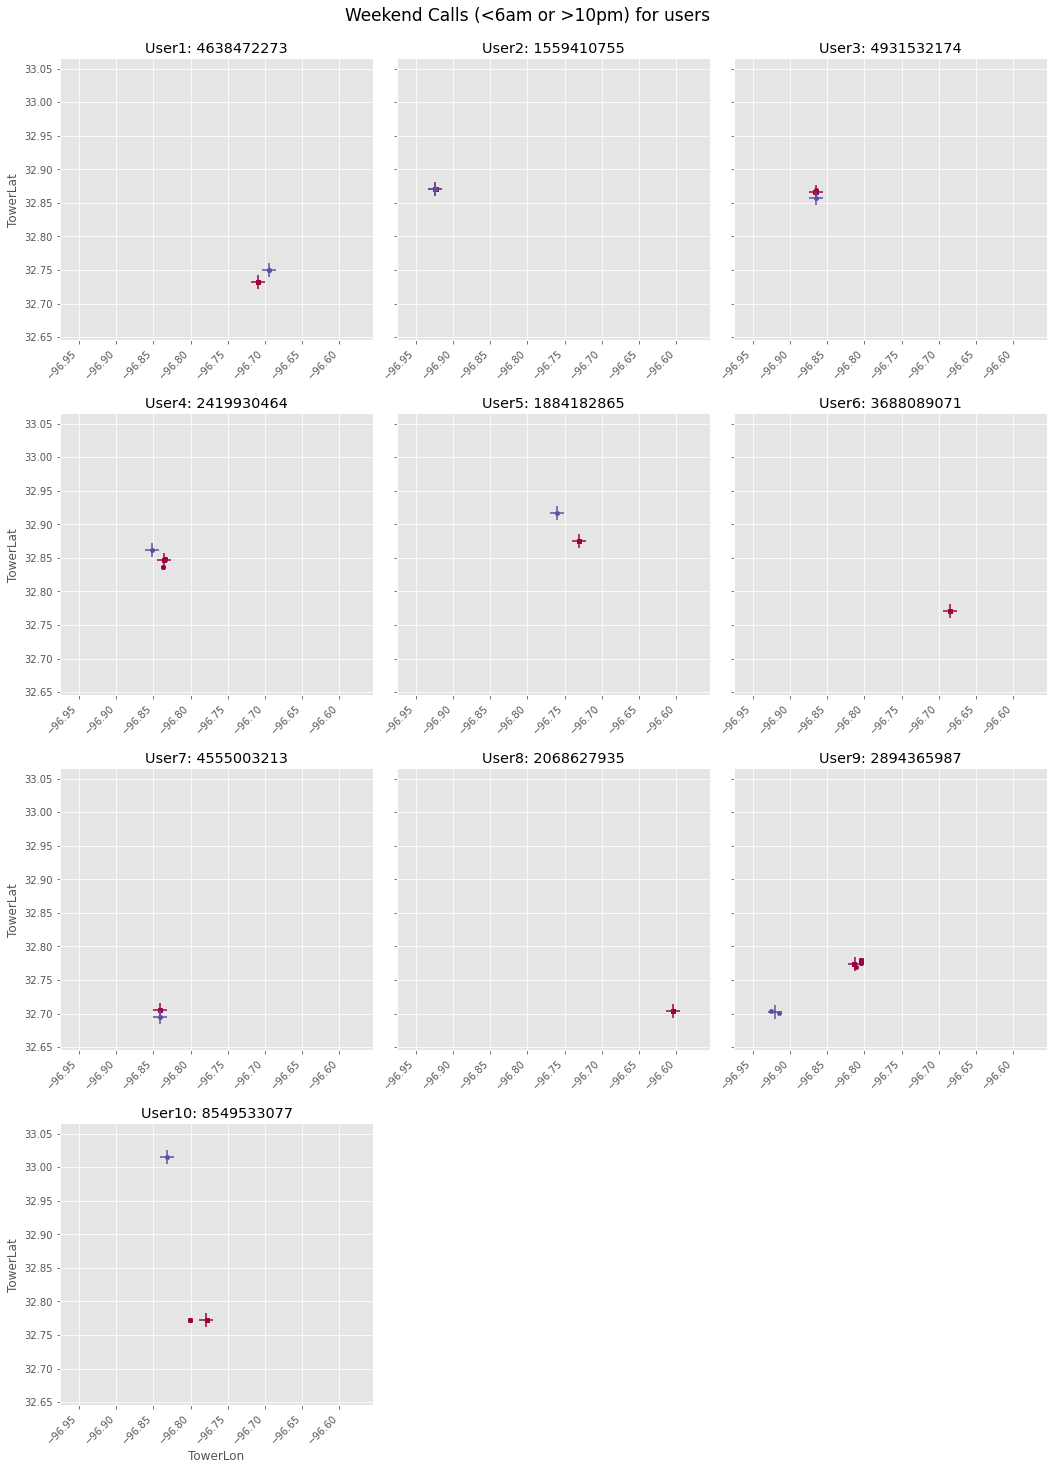

In [18]:
# plot clusters:
plt.figure(figsize=(15, 20))
# setting axis scale
x_min = data_weekends_hours['TowerLon'].min()
x_max = data_weekends_hours['TowerLon'].max()
y_min = data_weekends_hours['TowerLat'].min()
y_max = data_weekends_hours['TowerLat'].max()

for idx, user, model in zip(range(10), users_weekends, weekend_models):
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(model.labels_))))
    ax = plt.subplot(4, 3, idx+1)
    ax.set_xlim(x_min-0.05, x_max+0.05)
    ax.set_ylim(y_min-0.05, y_max+0.05)
    for k, col in zip(range(len(model.cluster_centers_)), colors):
        my_members = (model.labels_ == k)
        cluster_center = model.cluster_centers_[k]
        X = user.loc[my_members, 'TowerLon']
        Y = user.loc[my_members, 'TowerLat']
        ax.scatter(X, Y, color=col, marker='o', s=20)
        ax.scatter(cluster_center[0], cluster_center[1], color=col, marker='+', s=200)
        
    ax.ticklabel_format(useOffset=False)
    if idx%3 == 0:
        ax.set_ylabel('TowerLat')
    else:
        ax.set_yticklabels([])
    ax.set_title('User{}: {}'.format(idx+1, phone_numbers_list[idx]))
    plt.xticks(rotation=45, ha='right')
        
plt.tight_layout(pad=2, w_pad=2, h_pad=2)
plt.suptitle('Weekend Calls (<6am or >10pm) for users', size=17, y=1.01);
plt.xlabel('TowerLon');


**11. Alter your slice from user1, so that it includes only Weekday (Mon-Fri) values and before 5pm:**

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call/wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work or at the second, at home:
        

In [19]:
#TO DO:
user1_weekdays = user1[user1.weekends==False]
user1_weekdays_daytime = user1_weekdays.query('CallTime<"17:00:00"')
print(user1_weekdays_daytime.shape)
user1_weekdays_daytime.head()


(1405, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,weekends
197,4638472273,5481755331,Incoming,2010-12-28,16:20:11.532130,Tue,00:03:56.069765,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,False
200,4638472273,8180005891,Incoming,2010-12-28,15:27:51.105337,Tue,00:03:30.047757,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
248,4638472273,8180005891,Missed,2010-12-29,09:13:35.198987,Wed,00:02:10.574446,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
249,4638472273,2145623768,Incoming,2010-12-29,06:02:11.319738,Wed,00:04:34.436752,9baa92e7-e990-4e9e-8c0a-4c17cb4ecc7c,32.731611,-96.709417,False
250,4638472273,8068555700,Incoming,2010-12-29,13:54:14.724722,Wed,00:03:31.297111,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,False


**12. Plot the Cell Towers the above data frame:**


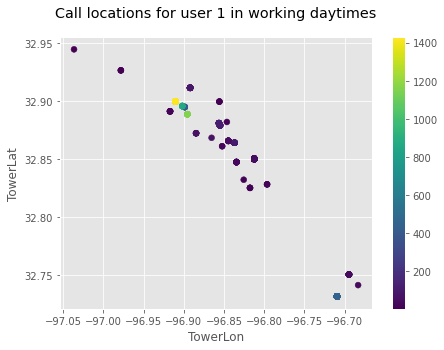

In [20]:
#TO DO:
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 

# Calculate the point density
x = user1_weekdays_daytime.TowerLon
y = user1_weekdays_daytime.TowerLat
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y, c=z, s=35,)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
plt.title('Call locations for user 1 in working daytimes', y=1.05)
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()


**13. Complete the doKmeans function:**

In [21]:
#TO DO:
def doKMeans(data, num_clusters=0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # .. your code here ..
    data = data.loc[:, ['TowerLon', 'TowerLat']]
    model = KMeans(init="k-means++", n_clusters=num_clusters, n_init=10)
    model.fit(data)
    return model


**14. Let's turn K-Means with `K=3`using doKMeans function for that dataframe (user1 on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

There should only be two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another).

In [22]:
#TO DO:
model = doKMeans(user1_weekdays_daytime, num_clusters=3)
clusterInfo(model)


  Cluster Analysis Inertia:  0.15891069523780382
  ----------------------------------------
    Cluster  0
      Centroid  [-96.70816184  32.73323174]
      #Samples  306
    Cluster  1
      Centroid  [-96.90951639  32.9000009 ]
      #Samples  959
    Cluster  2
      Centroid  [-96.83818346  32.86348712]
      #Samples  140


**15. Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it.** 

If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between midnight and 5pm?

In [23]:
#TO DO:
rows = clusterWithFewestSamples(model)
FewestSamples = user1_weekdays_daytime.loc[rows, 'CallTime']
CallTime_mean = FewestSamples.mean()
CallTime_mean



  Cluster With Fewest Samples:  2


Timedelta('0 days 07:49:53.168115')

**16. Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


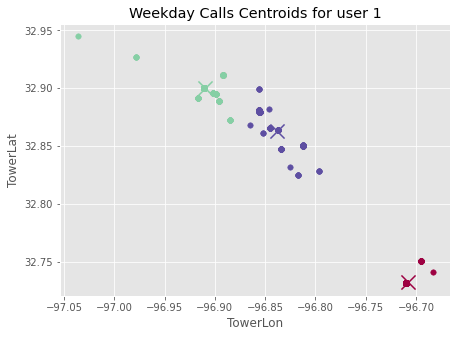

In [24]:
#TO DO:
fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.Spectral(np.linspace(0, 1.5, len(set(model.labels_))))
for k, col in zip(range(len(model.cluster_centers_)), colors):
    my_members = (model.labels_ == k)
    cluster_center = model.cluster_centers_[k]
    X = user1_weekdays_daytime.loc[my_members, 'TowerLon']
    Y = user1_weekdays_daytime.loc[my_members, 'TowerLat']
    ax.scatter(X, Y, color=col, marker='o', s=30)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, marker='x', s=200)

plt.title('Weekday Calls Centroids for user 1');
plt.xlabel('TowerLon');
plt.ylabel('TowerLat'); 


# Adanved part (15%  of the total score)

**17. Now that you have a system in place, repeat the the steps 12, 14 and 16 for all 10 individuals in the dataset.**

**Plot the Cell Towers for all users**


In [25]:
#Create data for each user
data_weekdays = data[data.weekends==False]
data_weekdays_daytime = data_weekdays.query('CallTime<"17:00:00"')
users_weekdays_daytime = []
for phone_number in phone_numbers_list:
    user = data_weekdays_daytime[data_weekdays_daytime.In==phone_number]
    users_weekdays_daytime.append(user)
users_weekdays_daytime[0].head()


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,weekends
197,4638472273,5481755331,Incoming,2010-12-28,16:20:11.532130,Tue,00:03:56.069765,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,False
200,4638472273,8180005891,Incoming,2010-12-28,15:27:51.105337,Tue,00:03:30.047757,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
248,4638472273,8180005891,Missed,2010-12-29,09:13:35.198987,Wed,00:02:10.574446,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
249,4638472273,2145623768,Incoming,2010-12-29,06:02:11.319738,Wed,00:04:34.436752,9baa92e7-e990-4e9e-8c0a-4c17cb4ecc7c,32.731611,-96.709417,False
250,4638472273,8068555700,Incoming,2010-12-29,13:54:14.724722,Wed,00:03:31.297111,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,False


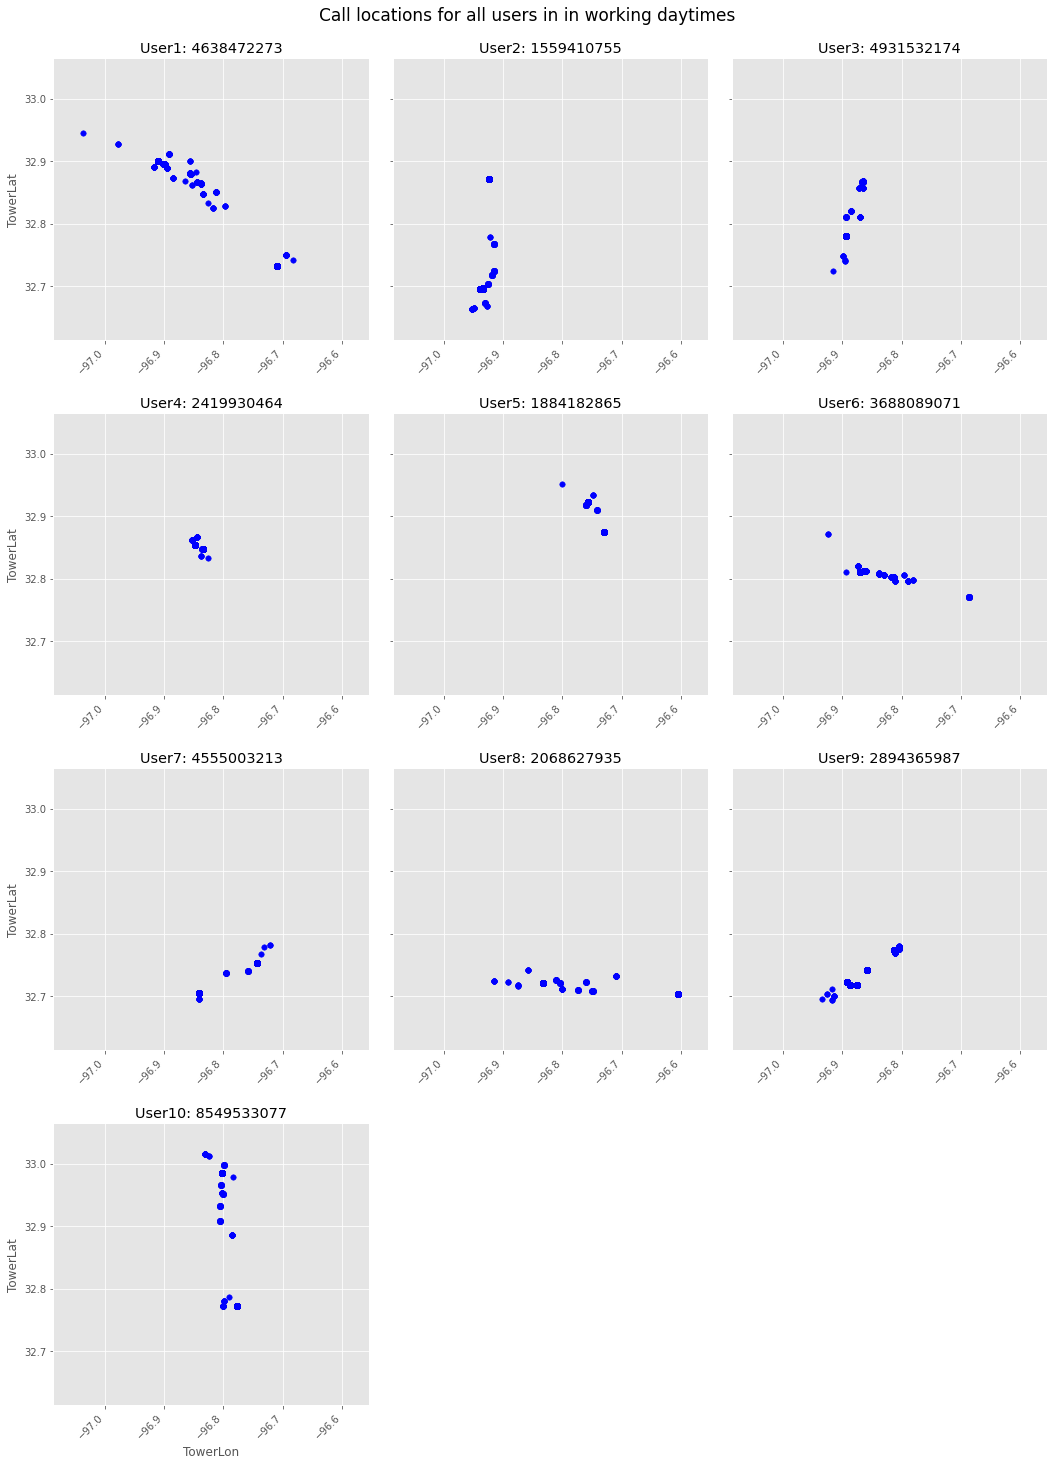

In [26]:
# Plot the call locations for all users in working daytimes.
plt.figure(figsize=(15, 20))
# setting axis scale
x_min = data_weekdays_daytime['TowerLon'].min()
x_max = data_weekdays_daytime['TowerLon'].max()
y_min = data_weekdays_daytime['TowerLat'].min()
y_max = data_weekdays_daytime['TowerLat'].max()

for idx, user in enumerate(users_weekdays_daytime):
    ax = plt.subplot(4, 3, idx+1)
    X = user['TowerLon']
    Y = user['TowerLat']
    ax.scatter(X, Y, color='blue', marker='o', s=30)
    ax.set_xlim(x_min-0.05, x_max+0.05)
    ax.set_ylim(y_min-0.05, y_max+0.05)        
    ax.ticklabel_format(useOffset=False)
    if idx%3 == 0:
        ax.set_ylabel('TowerLat')
    else:
        ax.set_yticklabels([])
    ax.set_title('User{}: {}'.format(idx+1, phone_numbers_list[idx]))
    plt.xticks(rotation=45, ha='right')
        
plt.tight_layout(pad=2, w_pad=2, h_pad=2)
plt.suptitle('Call locations for all users in in working daytimes', size=17, y=1.01);
plt.xlabel('TowerLon');


**Let's turn K-Means with `K=3`using doKMeans function for *data_weekdays_daytime* dataframe (all users on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

In [27]:
# Run K-Means for all users
weekday_models = []
for idx, user, in enumerate(users_weekdays_daytime):
    model = doKMeans(user, num_clusters=3)
    weekday_models.append(model)
    print('\nUser{}: {}'.format(idx+1, phone_numbers_list[idx]))
    clusterInfo(model)
    


User1: 4638472273
  Cluster Analysis Inertia:  0.15891069523780382
  ----------------------------------------
    Cluster  0
      Centroid  [-96.83818346  32.86348712]
      #Samples  140
    Cluster  1
      Centroid  [-96.70816184  32.73323174]
      #Samples  306
    Cluster  2
      Centroid  [-96.90951639  32.9000009 ]
      #Samples  959

User2: 1559410755
  Cluster Analysis Inertia:  0.26574461775828684
  ----------------------------------------
    Cluster  0
      Centroid  [-96.93522725  32.69557708]
      #Samples  3121
    Cluster  1
      Centroid  [-96.92355104  32.87096795]
      #Samples  921
    Cluster  2
      Centroid  [-96.9164561   32.73762409]
      #Samples  360

User3: 4931532174
  Cluster Analysis Inertia:  0.019550969878115054
  ----------------------------------------
    Cluster  0
      Centroid  [-96.89338791  32.77992299]
      #Samples  846
    Cluster  1
      Centroid  [-96.86563953  32.86562866]
      #Samples  197
    Cluster  2
      Centroid  [-

**Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


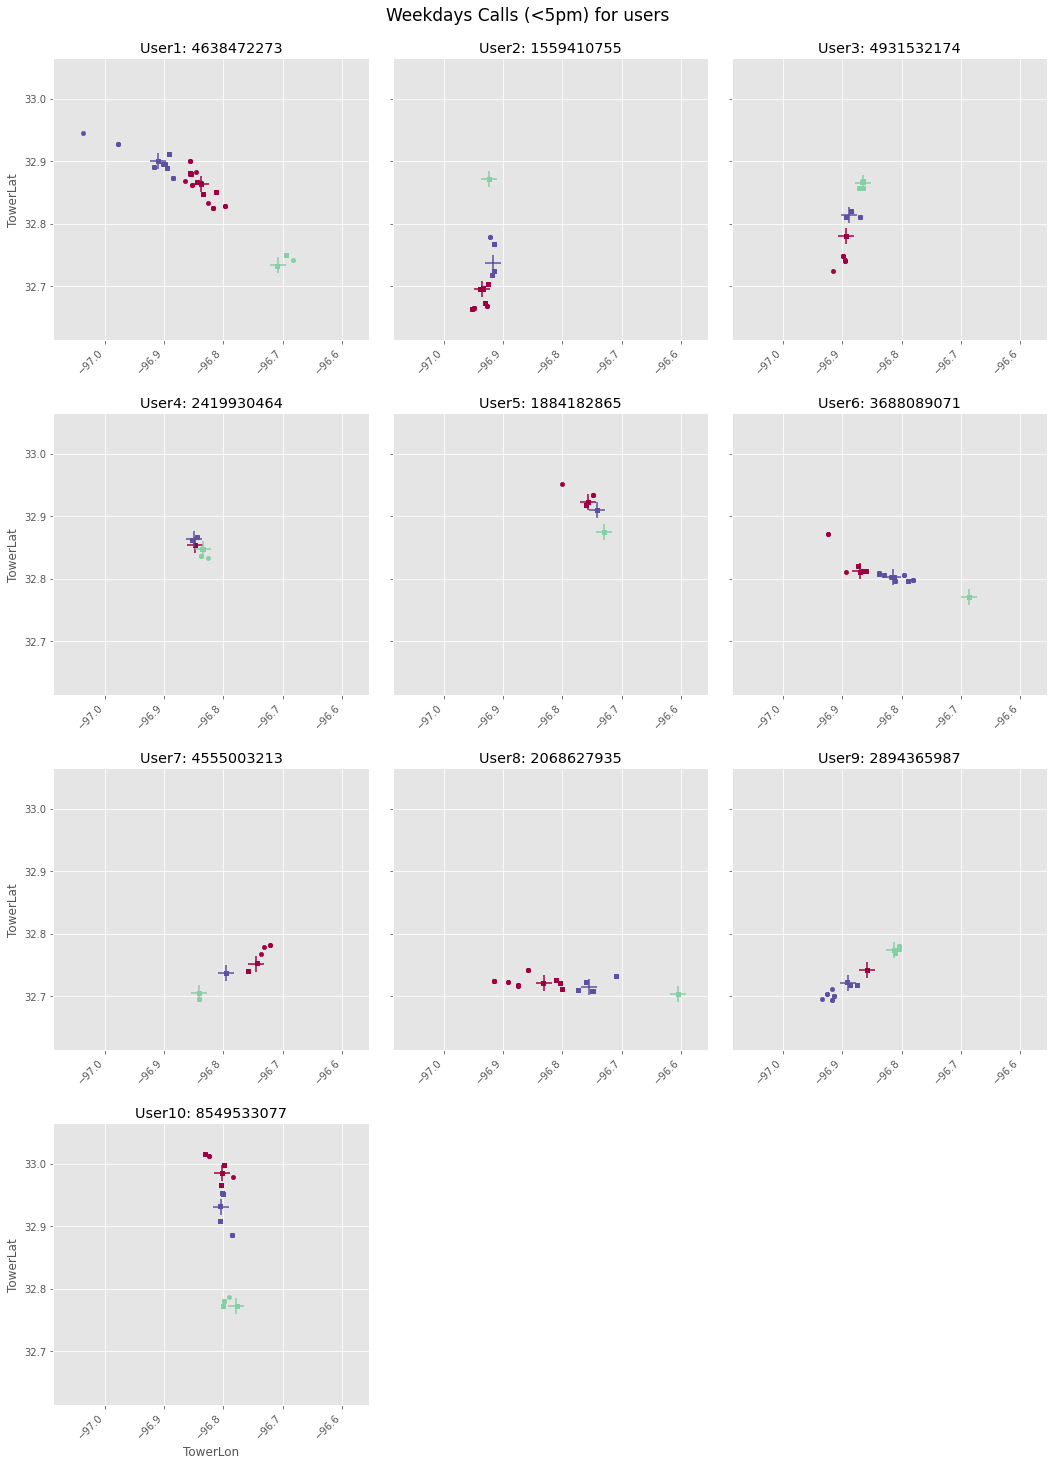

In [28]:
# plot clusters:
plt.figure(figsize=(15, 20))
# setting axis scale
x_min = data_weekdays_daytime['TowerLon'].min()
x_max = data_weekdays_daytime['TowerLon'].max()
y_min = data_weekdays_daytime['TowerLat'].min()
y_max = data_weekdays_daytime['TowerLat'].max()

for idx, user, model in zip(range(10), users_weekdays_daytime, weekday_models):
    colors = plt.cm.Spectral(np.linspace(0, 1.5, len(set(model.labels_))))
    ax = plt.subplot(4, 3, idx+1)
    ax.set_xlim(x_min-0.05, x_max+0.05)
    ax.set_ylim(y_min-0.05, y_max+0.05)
    for k, col in zip(range(len(model.cluster_centers_)), colors):
        my_members = (model.labels_ == k)
        cluster_center = model.cluster_centers_[k]
        X = user.loc[my_members, 'TowerLon']
        Y = user.loc[my_members, 'TowerLat']
        ax.scatter(X, Y, color=col, marker='o', s=20)
        ax.scatter(cluster_center[0], cluster_center[1], color=col, marker='+', s=250)
        
    ax.ticklabel_format(useOffset=False)
    if idx%3 == 0:
        ax.set_ylabel('TowerLat')
    else:
        ax.set_yticklabels([])
    ax.set_title('User{}: {}'.format(idx+1, phone_numbers_list[idx]))
    plt.xticks(rotation=45, ha='right')
        
plt.tight_layout(pad=2, w_pad=2, h_pad=2)
plt.suptitle('Weekdays Calls (<5pm) for users', size=17, y=1.01);
plt.xlabel('TowerLon');
